In [1]:
%cd ..

/Users/crupley/gal/hoodie


In [95]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cPickle as pickle
import networkx as nx

import code.featurize as fe
import code.graph as gr

plt.rcParams['figure.figsize'] = 16, 10

In [4]:
f = pickle.load(open('features.pkl', 'rb'))
df = f.fsmooth
edges = pickle.load(open('edges.pkl', 'rb'))

In [6]:
g = nx.from_pandas_dataframe(edges, source='node1', target='node2')
gr.graph_info(g)

Name: 
Type: Graph
Number of nodes: 7325
Number of edges: 23555
Average degree:   6.4314
Number of clusters: 5
Largest cluster: 7295


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7334 entries, 0 to 7333
Data columns (total 11 columns):
lat              7334 non-null float64
lon              7334 non-null float64
taxable_value    7334 non-null float64
grocery          7334 non-null float64
restaurant       7334 non-null float64
retail           7334 non-null float64
ncrimes          7334 non-null float64
sgnf             7334 non-null float64
avg_hh_size      7334 non-null float64
population       7334 non-null float64
walkscore        7334 non-null float64
dtypes: float64(11)
memory usage: 687.6 KB


# smaller subset

In [10]:
dfsm = fe.window(df, 37.78, 37.82, -122.43, -122.37)
print dfsm.shape
dfsm.head()

(917, 11)


,lat,lon,taxable_value,grocery,restaurant,retail,ncrimes,sgnf,avg_hh_size,population,walkscore
37,37.783777,-122.410027,1.056590,2.439579,2.368462,3.064399,8.736206,-0.317279,-0.838835,2.675795,1.004704
39,37.791720,-122.407853,1.080657,2.908979,1.299537,4.742132,1.882118,0.895598,-0.405471,1.780197,1.002301
54,37.780350,-122.392376,-0.343607,0.172258,0.800260,0.272760,0.086415,0.246032,-0.962838,-0.204230,0.578977
78,37.794221,-122.410217,0.517677,3.095271,-0.103176,2.873777,0.645622,1.073511,0.189218,2.243028,1.007293
79,37.799018,-122.424076,0.622622,0.162230,0.195028,0.472734,-0.051851,0.615914,-0.417202,1.357245,0.936546


In [11]:
%time edsm = gr.make_edges(dfsm)

CPU times: user 1min 35s, sys: 519 ms, total: 1min 35s
Wall time: 1min 36s


In [12]:
g = gr.make_graph(edsm, edge_attr=None)
gr.graph_info(g)

Name: 
Type: Graph
Number of nodes: 914
Number of edges: 2120
Average degree:   4.6389
Number of clusters: 1
Largest cluster: 914


In [26]:
knum = 2
dfsm['group'] = -1

# initialize nodes
nodes = np.random.choice(dfsm.index, size=knum, replace=False)
for gr, node in enumerate(nodes):
    dfsm.group.loc[node] = gr

In [27]:
dfsm.group[dfsm.group != -1]

6741    1
7203    0
Name: group, dtype: int64

In [24]:
nodes

array([3277, 5389])

In [77]:
groupavg = dfsm.groupby('group').mean()
groupavg

,lat,lon,taxable_value,grocery,restaurant,retail,ncrimes,sgnf,avg_hh_size,population,walkscore
group,,,,,,,,,,,
-1,37.793220,-122.410621,0.759770,1.575989,1.466673,1.862556,1.312597,-0.027142,-0.773548,1.039080,0.830316
0,37.788832,-122.421129,1.074065,1.124708,2.195885,1.144726,1.792758,-0.035453,-0.532428,2.843216,0.986025
1,37.788123,-122.389433,-1.203267,0.037864,0.057661,0.187186,-0.008514,-0.495874,-1.628805,-0.624841,0.108339


In [82]:
# build distance sets
dist = pd.DataFrame(columns=['group', 'node'])

for k in xrange(knum):
    groupnodes = set(dfsm[dfsm.group == k].index)
    neibnodes = set()
    for node in groupnodes:
        neibnodes = neibnodes.union(set(nx.all_neighbors(g, node)))
    # remove group nodes from list
    neibnodes = neibnodes.difference(groupnodes)
    newrows = pd.DataFrame({'group': k * np.ones(len(neibnodes)),
                            'node': list(neibnodes)})
    dist = dist.append(newrows, ignore_index=True).astype('int')
dist

,group,node
0,0,1320
1,0,1857
2,0,7307
3,0,6797
4,0,3431
5,1,2986
6,1,5939
7,1,5940
8,1,142


In [78]:
def calc_dist(row):
    return fe.sim(groupavg.ix[row.group][2:], dfsm.ix[row.node][2:-1])

row = dist.ix[0]
calc_dist(row)

0.94546248258678189

In [83]:
dist['dist'] = dist.apply(calc_dist, axis=1)
dist.head()

,group,node,dist
0,0,1320,0.945462
1,0,1857,0.232202
2,0,7307,1.327948
3,0,6797,1.008243
4,0,3431,0.242494


In [86]:
dist.sort_values('dist')

,group,node,dist
1,0,1857,0.232202
4,0,3431,0.242494
7,1,5940,0.557786
8,1,142,0.665067
6,1,5939,0.850988
5,1,2986,0.909096
0,0,1320,0.945462
3,0,6797,1.008243
2,0,7307,1.327948


In [88]:
dist.sort_values('dist').iloc[0]

group       0.000000
node     1857.000000
dist        0.232202
Name: 1, dtype: float64

In [90]:
# assign nearest node to group
bestmatch = dist.sort_values('dist').iloc[0]
dfsm.group.loc[dfsm.index == bestmatch.node] = bestmatch.group
dfsm.group[dfsm.group != -1]

1857    0
6741    1
7203    0
Name: group, dtype: float64

In [154]:

knum = 4
nodes = np.random.choice(dfsm.index, size=knum, replace=False)


In [171]:
%%time
dfsm['group'] = -1

# initialize nodes
for gr, node in enumerate(nodes):
    dfsm.group.loc[node] = gr

    
for i in xrange(1000):
    groupavg = dfsm.groupby('group').mean()
    groupednodes = set(dfsm.index[dfsm.group != -1].astype('int'))

    # build distance sets
    dist = pd.DataFrame(columns=['group', 'node'])

    for k in xrange(knum):
        nodegroup = set(dfsm[dfsm.group == k].index)
        neibnodes = set()
        for node in nodegroup:
            neibnodes = neibnodes.union(set(nx.all_neighbors(g, node)))
        # remove group nodes from list
        neibnodes = neibnodes.difference(groupednodes)
        newrows = pd.DataFrame({'group': k * np.ones(len(neibnodes)),
                                'node': list(neibnodes)})
        dist = dist.append(newrows, ignore_index=True).astype('int')

    if dist.shape[0] == 0: break
    dist['dist'] = dist.apply(calc_dist, axis=1)

    # assign nearest node to group
    bestmatch = dist.sort_values('dist').iloc[0]
    dfsm.group.loc[dfsm.index == bestmatch.node] = bestmatch.group

CPU times: user 1min 9s, sys: 220 ms, total: 1min 9s
Wall time: 1min 9s


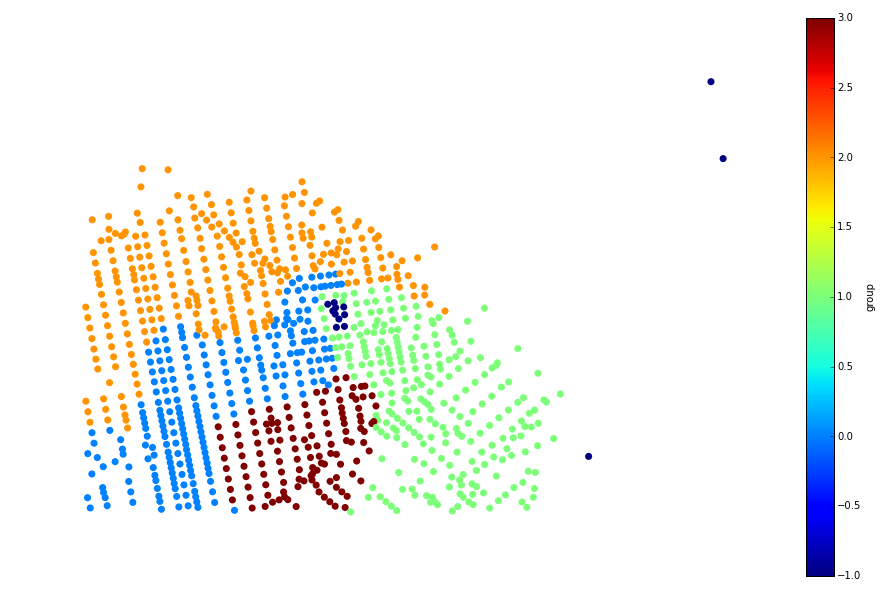

In [167]:
dfsm.plot(kind='scatter', x='lon', y='lat', c='group', cmap='jet', linewidths=0, s=50)
plt.margins(0)
plt.axis('off');

In [158]:
dist.sort_values('dist').head()

,group,node,dist
45,0,3043,1.127332
59,2,5911,1.129679
73,2,1986,1.130098
15,0,5803,1.138665
78,2,1361,1.140619


In [161]:
dfsm.ix[5911]

lat               37.797264
lon             -122.422831
taxable_value      0.532228
grocery            0.309169
restaurant         0.737073
retail             0.590997
ncrimes            0.035251
sgnf               0.785415
avg_hh_size       -0.293088
population         1.775799
walkscore          0.944246
group             -1.000000
Name: 5911, dtype: float64

In [160]:
bestmatch

group       0.000000
node     3043.000000
dist        1.127332
Name: 45, dtype: float64

In [164]:
3043 in groupednodes

True

In [101]:
-1 in dfsm.group.values

True

In [146]:
print len(groupednodes)
print len(neibnodes)
print newrows.shape
print dist.shape
bestmatch

740
69
(69, 2)
(96, 3)


group       1.000000
node     3327.000000
dist        3.999672
Name: 93, dtype: float64

In [152]:
len([i for i in newrows.node if i in dfsm.ix[dfsm.group == -1].index.values])

51

In [153]:
newrows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69 entries, 0 to 68
Data columns (total 2 columns):
group    69 non-null float64
node     69 non-null int64
dtypes: float64(1), int64(1)
memory usage: 1.6 KB


(96, 3)

In [168]:
dfsm.groupby('group').count()

,lat,lon,taxable_value,grocery,restaurant,retail,ncrimes,sgnf,avg_hh_size,population,walkscore
group,,,,,,,,,,,
-1,13,13,13,13,13,13,13,13,13,13,13
0,233,233,233,233,233,233,233,233,233,233,233
1,253,253,253,253,253,253,253,253,253,253,253
2,294,294,294,294,294,294,294,294,294,294,294
3,124,124,124,124,124,124,124,124,124,124,124


In [144]:
dfsm.groupby('group').mean()

,lat,lon,taxable_value,grocery,restaurant,retail,ncrimes,sgnf,avg_hh_size,population,walkscore
group,,,,,,,,,,,
-1,37.787866,-122.408950,0.783035,2.321332,2.728435,3.357528,4.392747,-0.243311,-0.853598,1.980840,0.829121
0,37.797314,-122.406300,0.640491,6.701643,4.819098,3.898163,0.923433,0.598391,-0.197378,0.778707,1.052843
1,37.794206,-122.411475,0.763076,0.866726,0.800069,1.263166,0.540006,-0.033273,-0.810767,0.817526,0.807635
